In [23]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict ,Annotated
from dotenv import load_dotenv
from pydantic import BaseModel,Field
import operator
import os

In [24]:
load_dotenv()
model = ChatOpenAI(model=os.getenv("MODEL_NAME"))

In [34]:
essay = """
Indian startups have emerged as a major force in the global entrepreneurial landscape, driven by technological innovation, expanding digital infrastructure, and a young, ambitious population. Over the past decade, India has become the world’s third-largest startup ecosystem, with ventures spanning sectors such as fintech, edtech, healthtech, e-commerce, and deep technology. This growth has been accelerated by widespread smartphone adoption, affordable internet access, and supportive government initiatives like Startup India, Digital India, and Make in India, which have reduced regulatory barriers and encouraged innovation.
"""

In [35]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description="detailed feedback of the essay")
    score: int = Field(description="score out of 100", ge=0, le=100)


structured_model = model.with_structured_output(EvaluationSchema)

response = structured_model.invoke(
    f"evaluate the language quality of the essay \n {essay}"
)
print(response.feedback)
print(response.score)


KeyboardInterrupt: 

In [36]:
class EssayEvaluationState(TypedDict):
    essay: str

    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str

    individual_scores: Annotated[list[int], operator.add]
    overall_score: float

In [37]:
def evaluate_language(state: EssayEvaluationState) -> EssayEvaluationState:
    response = structured_model.invoke(
        f"evaluate the language quality of the essay \n {state['essay']}"
    )
    return {
        "language_feedback": response.feedback,
        "individual_scores": [response.score],
    }

In [38]:
def evaluate_analysis(state: EssayEvaluationState) -> EssayEvaluationState:
    response = structured_model.invoke(
        f"evaluate the depth of analysis of the essay \n {state['essay']}"
    )
    return {
        "analysis_feedback": response.feedback,
        "individual_scores": [response.score],
    }

In [39]:
def evaluate_clarity(state: EssayEvaluationState) -> EssayEvaluationState:
    response = structured_model.invoke(
        f"evaluate the clarity of the essay \n {state['essay']}"
    )
    return {
        "clarity_feedback": response.feedback,
        "individual_scores": [response.score],
    }

In [40]:
def final_evaluation(state: EssayEvaluationState) -> EssayEvaluationState:

    overall_feedback = model.invoke(
        f"give overall feedback considering this 3 feedbacks \n feedback on language -> {state['language_feedback']} \n feedback on depth of analysis -> {state['analysis_feedback']} \n feedback on clarity -> {state['clarity_feedback']}"
    ).content

    overall_score = sum(state["individual_scores"]) / len(state["individual_scores"])
    return {
        "overall_feedback": overall_feedback,
        "overall_score": overall_score,
    }

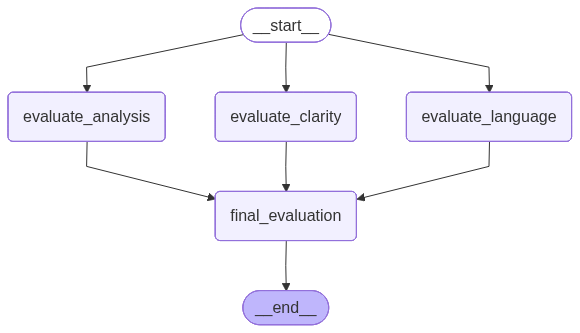

In [41]:
graph = StateGraph(EssayEvaluationState)

graph.add_node("evaluate_language", evaluate_language)
graph.add_node("evaluate_analysis", evaluate_analysis)
graph.add_node("evaluate_clarity", evaluate_clarity)
graph.add_node("final_evaluation", final_evaluation)

graph.add_edge(START, "evaluate_language")
graph.add_edge(START, "evaluate_analysis")
graph.add_edge(START, "evaluate_clarity")

graph.add_edge("evaluate_language", "final_evaluation")
graph.add_edge("evaluate_analysis", "final_evaluation")
graph.add_edge("evaluate_clarity", "final_evaluation")

graph.add_edge("final_evaluation", END)

workflow = graph.compile()
workflow

In [42]:
final_result = workflow.invoke({"essay":essay})
final_result

{'essay': '\nIndian startups have emerged as a major force in the global entrepreneurial landscape, driven by technological innovation, expanding digital infrastructure, and a young, ambitious population. Over the past decade, India has become the world’s third-largest startup ecosystem, with ventures spanning sectors such as fintech, edtech, healthtech, e-commerce, and deep technology. This growth has been accelerated by widespread smartphone adoption, affordable internet access, and supportive government initiatives like Startup India, Digital India, and Make in India, which have reduced regulatory barriers and encouraged innovation.\n',
 'language_feedback': "Overall, the essay demonstrates high language quality: clear argument, cohesive flow, and precise, formal diction. The parallel structure in the opening drivers and the list of sectors is effective, and the sentence length is balanced. A few minor tweaks could tighten the prose: (1) use 'In the past decade' instead of 'Over the